In [11]:
import os
import requests
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
from app_import.NEOs import NEOs, load_neos

# Load API Key from .env file
load_dotenv()
NASA_API_KEY = os.getenv('NASA_API_KEY')

neos = load_neos(1e-6, -4, 0)

for neo in neos:
    neo.get_data_and_summary()

neolist = [neo.name for neo in neos]


class NasaAPINEOClient:
    API_ENDPOINT = "https://api.nasa.gov/neo/rest/v1/neo/"

    def __init__(self, api_key):
        self.api_key = api_key
        self.data = []

    def fetch_neo_details(self, asteroid_id):
        """
        Fetch details of a specific NEO by its asteroid ID.
        """
        response = requests.get(f"{self.API_ENDPOINT}{asteroid_id}", params={'api_key': self.api_key})
        
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error fetching {asteroid_id}: {response.status_code}")
            return None

    def get_selected_neo_details(self):
        """
        Fetch detailed data for only the NEOs in the 'neolist'.
        """
        for asteroid_id in neolist:
            details = self.fetch_neo_details(asteroid_id)
            if details:
                for approach in details["close_approach_data"]:
                    self.data.append({

                        "name": details["name"],
                        "is_potentially_hazardous": details.get("is_potentially_hazardous_asteroid"),
                        "is_sentry_object": details.get("is_sentry_object"),
                        "diameter_min_meters": details["estimated_diameter"]["meters"]["estimated_diameter_min"],
                        "diameter_max_meters": details["estimated_diameter"]["meters"]["estimated_diameter_max"],
                        "close_approach_date": approach["close_approach_date"],
                        "relative_velocity_km_h": approach["relative_velocity"]["kilometers_per_hour"],
                        "miss_distance_km": approach["miss_distance"]["kilometers"],
                        "orbiting_body": approach["orbiting_body"],
                        "first_observation_date": details["orbital_data"].get("first_observation_date"),
                        "last_observation_date": details["orbital_data"].get("last_observation_date"),
                        "observations_used": details["orbital_data"].get("observations_used"),
                        "orbit_uncertainty": details["orbital_data"].get("orbit_uncertainty"),
                        "minimum_orbit_intersection": details["orbital_data"].get("minimum_orbit_intersection"),
                        "inclination": details["orbital_data"].get("inclination"),
                        "orbital_period": details["orbital_data"].get("orbital_period")
                    })

        return pd.DataFrame(self.data)

if __name__ == "__main__":
    client = NasaAPINEOClient(NASA_API_KEY)
    df = client.get_selected_neo_details()

Error fetching 101955: 404
Error fetching 29075: 404


In [12]:
# Convert columns to appropriate numerical types
df['relative_velocity_km_h'] = pd.to_numeric(df['relative_velocity_km_h'], errors='coerce')
df['miss_distance_km'] = pd.to_numeric(df['miss_distance_km'], errors='coerce')
df['orbit_uncertainty'] = pd.to_numeric(df['orbit_uncertainty'], errors='coerce')
df['minimum_orbit_intersection'] = pd.to_numeric(df['minimum_orbit_intersection'], errors='coerce')
df['inclination'] = pd.to_numeric(df['inclination'], errors='coerce')
df['orbital_period'] = pd.to_numeric(df['orbital_period'], errors='coerce')

# Perform the groupby operation
grouped_df = df.groupby('name').agg({
    'is_potentially_hazardous': 'first',
    'is_sentry_object': 'first',
    'diameter_min_meters': 'mean',
    'diameter_max_meters': 'mean',
    'close_approach_date': 'count',  # Count the number of close approaches
    'relative_velocity_km_h': 'mean',
    'miss_distance_km': 'mean',
    'orbiting_body': lambda x: ', '.join(set(x)),  # Combine unique orbiting bodies
    'first_observation_date': 'first',
    'last_observation_date': 'first',
    'observations_used': 'sum',
    'orbit_uncertainty': 'first',
    'minimum_orbit_intersection': 'first',
    'inclination': 'first',
    'orbital_period': 'first'
}).rename(columns={'close_approach_date': 'close_approach_count'})

print(grouped_df)

              is_potentially_hazardous  is_sentry_object  diameter_min_meters  \
name                                                                            
(2000 SB45)                      False              True            33.462237   
(2000 SG344)                     False              True            30.517923   
(2005 QK76)                      False              True            25.383703   
(2006 DM63)                      False              True            12.149404   
(2007 DX40)                      False              True            31.956189   
(2007 KE4)                       False              True            24.241248   
(2008 EX5)                       False              True            46.190746   
(2008 JL3)                       False              True            23.150212   
(2008 UB7)                       False              True            50.647146   
(2010 RF12)                      False              True             5.502436   
(2012 HG2)                  

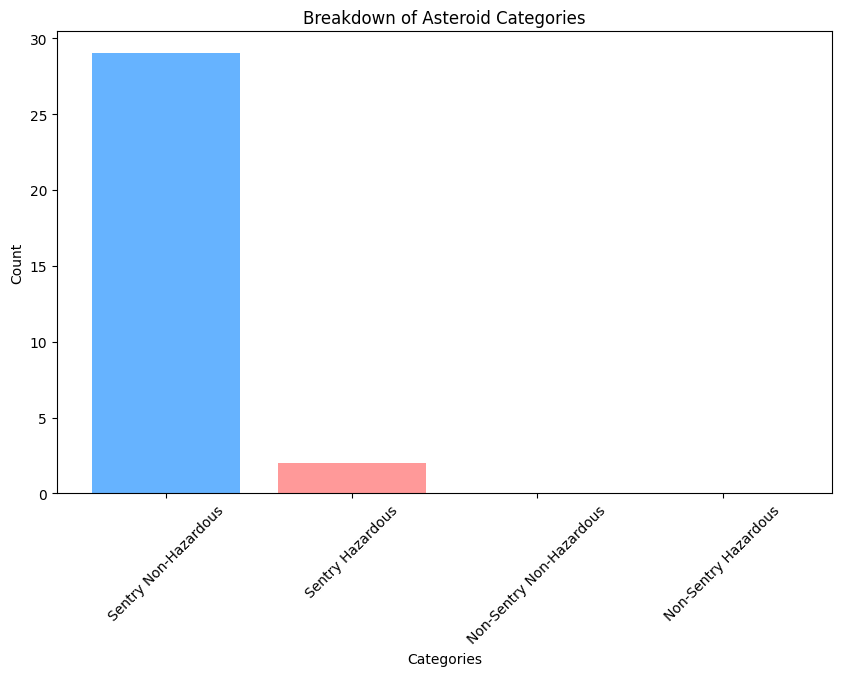

In [13]:
# Calculate the counts for each category
sentry_non_hazardous = len(grouped_df[grouped_df['is_sentry_object'] & ~grouped_df['is_potentially_hazardous']])
sentry_hazardous = len(grouped_df[grouped_df['is_sentry_object'] & grouped_df['is_potentially_hazardous']])
non_sentry_non_hazardous = len(grouped_df[~grouped_df['is_sentry_object'] & ~grouped_df['is_potentially_hazardous']])
non_sentry_hazardous = len(grouped_df[~grouped_df['is_sentry_object'] & grouped_df['is_potentially_hazardous']])

# Data for the bar chart
categories = ['Sentry Non-Hazardous', 'Sentry Hazardous', 'Non-Sentry Non-Hazardous', 'Non-Sentry Hazardous']
counts = [sentry_non_hazardous, sentry_hazardous, non_sentry_non_hazardous, non_sentry_hazardous]

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(categories, counts, color=['#66b3ff', '#ff9999', '#99ff99', '#ffcc99'])
plt.xlabel('Categories')
plt.ylabel('Count')
plt.title('Breakdown of Asteroid Categories')
plt.xticks(rotation=45)
plt.show()

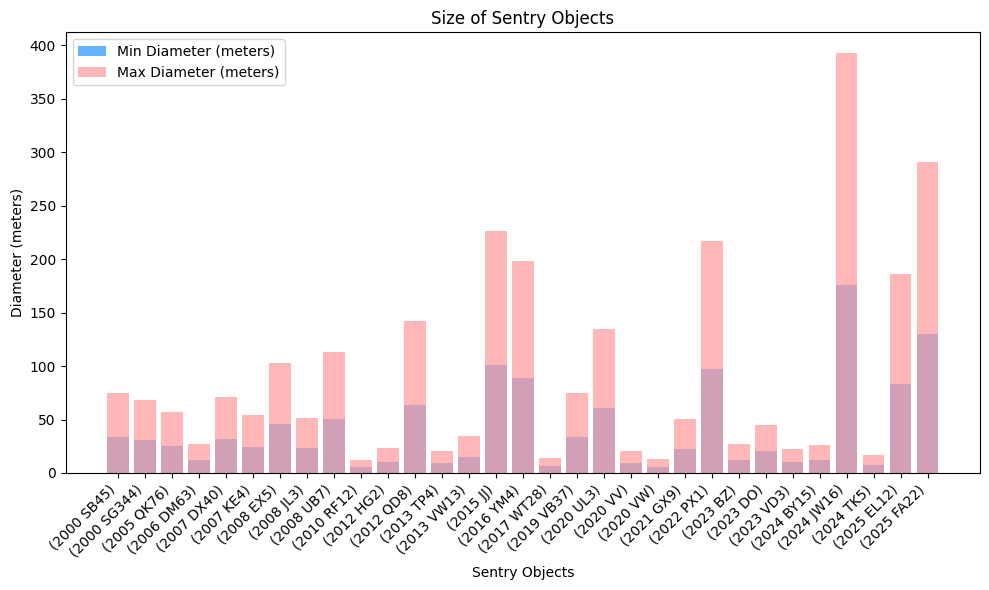

In [14]:
# Filter the grouped_df DataFrame to include only sentry objects
sentry_objects = grouped_df[grouped_df['is_sentry_object']]

# Plot the size of sentry objects
plt.figure(figsize=(10, 6))
plt.bar(sentry_objects.index, sentry_objects['diameter_min_meters'], label='Min Diameter (meters)', color='#66b3ff')
plt.bar(sentry_objects.index, sentry_objects['diameter_max_meters'], label='Max Diameter (meters)', color='#ff9999', alpha=0.7)

plt.xlabel('Sentry Objects')
plt.ylabel('Diameter (meters)')
plt.title('Size of Sentry Objects')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
neos = load_neos(1e-6, -4, 0)

for neo in neos:
    neo.get_data_and_summary()

In [17]:
neo_names = [neo.name for neo in neos]
print(neo_names)

['2000 SG344', '2008 JL3', '2010 RF12', '2006 DM63', '2017 WT28', '2012 QD8', '2016 YM4', '2000 SB45', '2008 UB7', '2013 VW13', '2023 BZ', '2012 HG2', '2013 TP4', '2007 KE4', '2008 EX5', '2021 GX9', '2005 QK76', '2015 JJ', '2020 VV', '2019 VB37', '2020 VW', '2007 DX40', '101955', '2022 PX1', '29075', '2023 DO', '2023 VD3', '2024 BY15', '2024 JW16', '2024 TK5', '2020 UL3', '2025 FA22', '2025 EL12']


In [18]:
neos[0].data

[{'energy': '1.046e+00',
  'ip': '1.064e-06',
  'date': '2122-08-04.72',
  'ps': '-6.43',
  'ts': '0',
  'sigma_vi': '0.0525'},
 {'energy': '1.047e+00',
  'ip': '8.303e-07',
  'date': '2122-08-03.24',
  'ps': '-6.53',
  'ts': '0',
  'sigma_vi': '1.2108'},
 {'energy': '1.047e+00',
  'ip': '5.524e-07',
  'date': '2122-08-01.42',
  'ts': '0',
  'ps': '-6.71',
  'sigma_vi': '1.1370'},
 {'ts': '0',
  'ps': '-6.65',
  'sigma_vi': '1.3550',
  'energy': '1.046e+00',
  'ip': '6.417e-07',
  'date': '2122-07-29.96'},
 {'date': '2121-09-16.76',
  'energy': '1.048e+00',
  'ip': '1.047e-06',
  'sigma_vi': '1.6464',
  'ps': '-6.43',
  'ts': '0'},
 {'ts': '0',
  'ps': '-7.89',
  'sigma_vi': '2.7283',
  'energy': '1.047e+00',
  'ip': '3.604e-08',
  'date': '2121-08-20.19'},
 {'ip': '7.769e-08',
  'energy': '1.047e+00',
  'date': '2121-08-17.54',
  'ts': '0',
  'ps': '-7.56',
  'sigma_vi': '2.7223'},
 {'ps': '-6.23',
  'ts': '0',
  'sigma_vi': '0.0869',
  'energy': '1.048e+00',
  'ip': '1.635e-06',
  'd